# Assignment 6: Training Fully-connected Neural Networks and CNNs

In [1]:
# enter your name and UFL email address
name = 'Yang Bai'
email = 'baiyang94@ufl.edu'

In [2]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 6 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import sklearn
    
    # we'll use tensorflow and keras for neural networks
    import tensorflow as tf
    import tensorflow.keras as keras
    
    # Load the TensorBoard notebook extension
    #%load_ext tensorboard

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('### Tensorflow version: ' + tf.__version__)
    print('### TF Keras version: ' + keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 6 -- name: Yang Bai, email: baiyang94@ufl.edu

### Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.1
### Tensorflow version: 2.4.1
### TF Keras version: 2.4.0
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### For this assignment we'll use the MNIST dataset, which contains images of handwritten digits.
### The task is to predict what digit a given image contains

In [4]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=True, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000, 10), (5000, 784), (5000, 10), (5000, 784), (5000, 10))

## First, let's setup some performance evaluation and plotting code

In [5]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [6]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, fs=(8,5)):
    plt.figure(figsize=fs)


    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)
    
    # Can you figure out why this makes sense? Why remove -0.5?
    plt.plot(epochs-0.5, train_loss, 'm', linewidth=2,  label='Loss (Training)')
    plt.plot(epochs-0.5, train_acc, 'r--', linewidth=2, label='Accuracy (Training)')
    
    plt.plot(epochs, val_loss, 'g', linewidth=2, label='Loss (Validation)')
    plt.plot(epochs, val_acc, 'b:', linewidth=2, label='Accuracy (Validation)')
    
    
    plt.xlim([0, num_epochs])
    plt.ylim([0, 1.05])
    
    plt.legend()
    
    plt.show()

## [Task 1] (10 points) Complete (& Customize) Your Model Training and Evaluation Code

### [Task 1a] (10 points) Complete the implementation of evaluate_model(). You can customize it to add whatever evaluation functionality you like (e.g., classification report, error analysis, etc.). Make sure you like the way it shows you the information: you will use it throughout this assignment!

In [7]:
# Customize this function as you like but makes sure it is implemented correctly.    
# Note: If you need to change the method definition to add more arguments, make sure to make 
# the new arguments are optional (& have a sensible default value)
def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # get predictions from the model
    train_preds = model.predict(train_x)
    val_preds = model.predict(val_x)
    
    # measure the accuracy (as categorical accuracy since we have a softmax layer)
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(train_y, train_preds)
    train_acc = catacc_metric.result()
    
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(val_y, val_preds)
    val_acc = catacc_metric.result()
    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
    
    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
        
    if evaluate_on_test_set:
        ### Evaluate the model on the test data  and put the results in 'test_loss', 'test_acc' (set verbose=0)
        ###* put your code here (~1-2 lines) *###
        test_loss, test_acc = model.evaluate(x=test_x, y=test_y, verbose=0)
        
        print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))
        
    # You can add stuff here
    ###* put your code here (0+ lines) *###
    from sklearn.metrics import classification_report
    test_preds = model.predict(test_x)
    test_preds_one_hot = test_preds > 0.5
    print('--- Classification Report: ')
    print(classification_report(test_y, test_preds_one_hot, digits=4))
    
    return

# this is what we call to do the training
def train_model(model, max_epochs=25, batch_size=100, verbose=0, 
                   dataset=(train_x, train_y, val_x, val_y, test_x, test_y)):

    # unpack dataset
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # this is the callback we'll use for early stopping
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=4)
    
    # setup the performance data callback
    perf_data = np.zeros((max_epochs, 4))
    perf_eval_cb = PerfEvalCustomCallback(perf_data)
    
    hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose)
    
    eff_epochs = len(hobj.history['loss'])
    eval_data = (perf_data[0:eff_epochs,:], dataset) # tuple of evaluation data
    
    return eval_data

## In the following Tasks (Tasks 2 & 3) you are given code to define the architecture of a model and compile it. But there is an issue for each model (it's broken in some way), which you need to identify and fix. All the models (if fixed) should achieve 95%+ val/test accuracy

## To diagnose the issue you need to observe the broken model's training process. Then you need to fix it by making minimal changes. You will add 'if fixed:' branches in the code to implement the fix without modify the behavior in anyway whenever 'fixed=False'.

## [Task 2] (30 points) Diagnosing Simple Problems

### [Task 2a] (10 points) Consider the following model. It has one obvious problem which prevents the model from learning: the output layer's activation function and the loss are inconsistent. Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Hint: since the output layer's activation function is softmax (which makes sense since we have one-hot encoded class labels), the loss should be the cross entropy loss (see tf.keras losses).

In [8]:
def create_compile_model0(fixed, input_shape=784, num_outputs=10, verbose=True):
    name = 'Model0--Fixed' if fixed else 'Model0--Broken'
    hidden_widths=[300, 100]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros()))
    
    opt = keras.optimizers.Adam(lr=0.0025)
    
    if verbose:
        model.summary()
    
    if fixed:
        ###* put your code here (~1-2 lines) *###
        model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
        # comment/remove this line once you implement the fix
#         raise NotImplementedError 
        
    else:
        model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [9]:
## create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model0(False) 

# train
eval_data = train_model(model)

Model: "Model0--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 300)               235500    
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               30100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


[Model0--Broken] Training Accuracy: 10.225%, Validation Accuracy: 10.500%


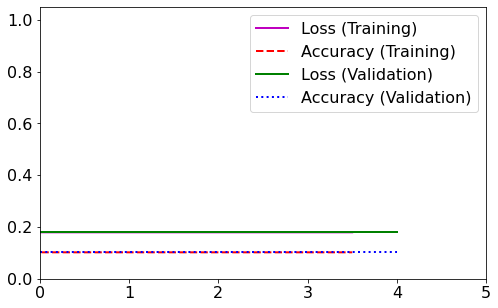

[Model0--Broken] Test loss: 0.18076, test accuracy: 9.620%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       484
           1     0.0000    0.0000    0.0000       540
           2     0.0000    0.0000    0.0000       510
           3     0.0962    1.0000    0.1755       481
           4     0.0000    0.0000    0.0000       490
           5     0.0000    0.0000    0.0000       407
           6     0.0000    0.0000    0.0000       509
           7     0.0000    0.0000    0.0000       540
           8     0.0000    0.0000    0.0000       496
           9     0.0000    0.0000    0.0000       543

   micro avg     0.0962    0.0962    0.0962      5000
   macro avg     0.0096    0.1000    0.0176      5000
weighted avg     0.0093    0.0962    0.0169      5000
 samples avg     0.0962    0.0962    0.0962      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# evaluate
evaluate_model(name, model, eval_data)

### Now let's check if you fixed the issue!

[Model0--Fixed] Training Accuracy: 98.243%, Validation Accuracy: 96.740%


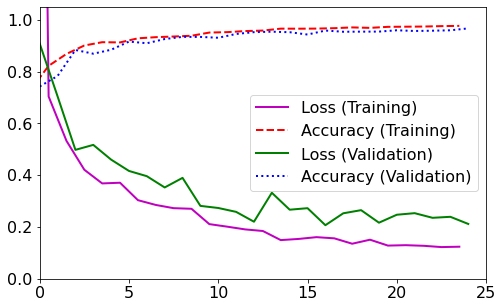

[Model0--Fixed] Test loss: 0.21992, test accuracy: 96.960%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9757    0.9938    0.9846       484
           1     0.9962    0.9778    0.9869       540
           2     0.9860    0.9686    0.9773       510
           3     0.9809    0.9605    0.9706       481
           4     0.9597    0.9714    0.9655       490
           5     0.9726    0.9607    0.9666       407
           6     0.9940    0.9764    0.9851       509
           7     0.9481    0.9815    0.9645       540
           8     0.9425    0.9577    0.9500       496
           9     0.9732    0.9374    0.9550       543

   micro avg     0.9727    0.9686    0.9706      5000
   macro avg     0.9729    0.9686    0.9706      5000
weighted avg     0.9730    0.9686    0.9707      5000
 samples avg     0.9686    0.9686    0.9686      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
## create and compile the model for fixed=True, train it, then evaluate it
name, model = create_compile_model0(True, verbose=False) 

# train
eval_data = train_model(model)

# evaluate
evaluate_model(name, model, eval_data)

### We see that the model works now; it achieves about 96% accuracy.

### [Task 2b] (5 points) Just like task 2a, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Note: the model is different in some ways to model0 but most of these ways are unrelated to the problem you are asked to diagnose and fix!

In [22]:
def create_compile_model1(fixed, input_shape=784, num_outputs=10, verbose=True):    
    name = 'Model1--Fixed' if fixed else 'Model1--Broken'
    hidden_widths=[256, 128, 48]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros(), use_bias=False))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    if fixed:
        ###* put your code here (~1-2 lines) *###
        opt = keras.optimizers.Adam(lr=0.0025)
        # comment/remove this line once you implement the fix
        # raise NotImplementedError 
    else:
        opt = keras.optimizers.Adam(lr=0.025)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [23]:
## create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model1(False) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model1--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 256)               200704    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               32768     
_________________________________________________________________
hidden_2 (Dense)             (None, 48)                6144      
_________________________________________________________________
output (Dense)               (None, 10)                490       
Total params: 240,106
Trainable params: 240,106
Non-trainable params: 0
_________________________________________________________________


[Model1--Broken] Training Accuracy: 11.235%, Validation Accuracy: 11.920%


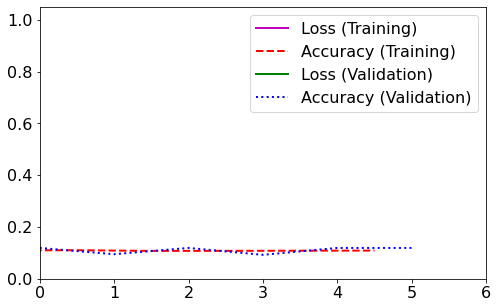

[Model1--Broken] Test loss: 2.30258, test accuracy: 10.800%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       484
           1     0.0000    0.0000    0.0000       540
           2     0.0000    0.0000    0.0000       510
           3     0.0000    0.0000    0.0000       481
           4     0.0000    0.0000    0.0000       490
           5     0.0000    0.0000    0.0000       407
           6     0.0000    0.0000    0.0000       509
           7     0.0000    0.0000    0.0000       540
           8     0.0000    0.0000    0.0000       496
           9     0.0000    0.0000    0.0000       543

   micro avg     0.0000    0.0000    0.0000      5000
   macro avg     0.0000    0.0000    0.0000      5000
weighted avg     0.0000    0.0000    0.0000      5000
 samples avg     0.0000    0.0000    0.0000      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [24]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 2c] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [25]:
###* put your answer here *###
#
# Answer:
# The problem was that the learning rate was too large.
# It prevents the model from convergence.
#

### Let's check if you fixed the issue.

[Model1--Fixed] Training Accuracy: 98.832%, Validation Accuracy: 96.980%


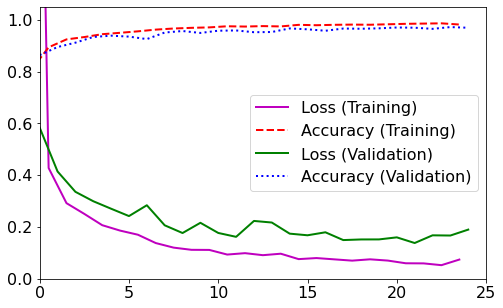

[Model1--Fixed] Test loss: 0.16956, test accuracy: 97.140%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9815    0.9855    0.9835       484
           1     0.9817    0.9907    0.9862       540
           2     0.9898    0.9490    0.9690       510
           3     0.9786    0.9522    0.9652       481
           4     0.9794    0.9714    0.9754       490
           5     0.9564    0.9705    0.9634       407
           6     0.9920    0.9745    0.9832       509
           7     0.9739    0.9667    0.9703       540
           8     0.9566    0.9778    0.9671       496
           9     0.9865    0.9411    0.9632       543

   micro avg     0.9780    0.9678    0.9729      5000
   macro avg     0.9776    0.9679    0.9726      5000
weighted avg     0.9782    0.9678    0.9728      5000
 samples avg     0.9678    0.9678    0.9678      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
name, model = create_compile_model1(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 2d] (5 points) Just like task 2a and task 2b, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [27]:
def create_compile_model2(fixed, input_shape=784, num_outputs=10, verbose=True):
    name = 'Model2--Fixed' if fixed else 'Model2--Broken'
    hidden_widths=[400, 96]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     use_bias=True))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output', use_bias=False))
    
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    if fixed:
        ###* put your code here (~1-2 lines) *###
        opt = keras.optimizers.RMSprop(lr=1e-4)
        # comment/remove this line once you implement the fix
        # raise NotImplementedError 
    else:
        opt = keras.optimizers.RMSprop(lr=1e-7)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [28]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model2(False) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model2--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 400)               314000    
_________________________________________________________________
hidden_1 (Dense)             (None, 96)                38496     
_________________________________________________________________
output (Dense)               (None, 10)                960       
Total params: 353,456
Trainable params: 353,456
Non-trainable params: 0
_________________________________________________________________


[Model2--Broken] Training Accuracy: 31.070%, Validation Accuracy: 30.880%


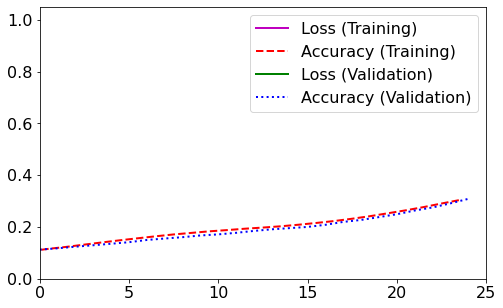

[Model2--Broken] Test loss: 32.87083, test accuracy: 30.100%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.5729    0.3492    0.4339       484
           1     0.3693    0.1963    0.2563       540
           2     0.3537    0.3863    0.3693       510
           3     0.3152    0.3617    0.3369       481
           4     0.1527    0.1939    0.1709       490
           5     0.3244    0.3587    0.3407       407
           6     0.4485    0.6071    0.5159       509
           7     0.2842    0.2463    0.2639       540
           8     0.1730    0.1653    0.1691       496
           9     0.1559    0.1731    0.1640       543

   micro avg     0.3012    0.3010    0.3011      5000
   macro avg     0.3150    0.3038    0.3021      5000
weighted avg     0.3136    0.3010    0.2998      5000
 samples avg     0.3010    0.3010    0.3010      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 2e] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [30]:
###* put your answer here *###
#
# Answer:
# The problem was that the learning rate was too small.
# It prevents the model from convergence under the given number of iteration epochs.
#

### Let's check if you fixed the issue.

[Model2--Fixed] Training Accuracy: 99.823%, Validation Accuracy: 96.080%


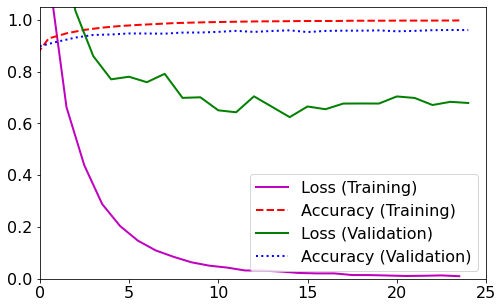

[Model2--Fixed] Test loss: 0.54336, test accuracy: 96.760%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9639    0.9917    0.9776       484
           1     0.9944    0.9870    0.9907       540
           2     0.9779    0.9549    0.9663       510
           3     0.9748    0.9667    0.9708       481
           4     0.9834    0.9694    0.9764       490
           5     0.9490    0.9607    0.9548       407
           6     0.9743    0.9666    0.9704       509
           7     0.9594    0.9630    0.9612       540
           8     0.9556    0.9556    0.9556       496
           9     0.9438    0.9595    0.9516       543

   micro avg     0.9678    0.9676    0.9677      5000
   macro avg     0.9677    0.9675    0.9675      5000
weighted avg     0.9679    0.9676    0.9677      5000
 samples avg     0.9676    0.9676    0.9676      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
name, model = create_compile_model2(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

## [Task 3] (30 points) Diagnosing Other Problems

### [Task 3a] (5 points) Just like in task 2, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [32]:
def create_compile_model3(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    name = 'Model3--Fixed' if fixed else 'Model3--Broken'
    hidden_widths=[512, 128, 32, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     bias_initializer=keras.initializers.RandomNormal(stddev=0.001), use_bias=True))
        
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    if fixed:
        ###* put your code here (~1-2 lines) *###
         model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                    kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                    bias_initializer=keras.initializers.Zeros(), use_bias=True))

        # comment/remove this line once you implement the fix
#         raise NotImplementedError 
    else:
        model.add(keras.layers.Dense(num_outputs, activation='tanh', name='output',
                                    kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                    bias_initializer=keras.initializers.Zeros(), use_bias=True))

    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.995, epsilon=1e-07, amsgrad=False)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [33]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model3(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=1)

Model: "Model3--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 512)               401920    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               65664     
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                4128      
_________________________________________________________________
hidden_3 (Dense)             (None, 24)                792       
_________________________________________________________________
output (Dense)               (None, 10)                250       
Total params: 472,754
Trainable params: 472,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
600/600 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.0983 - val_loss: nan

[Model3--Broken] Training Accuracy: 9.853%, Validation Accuracy: 10.140%


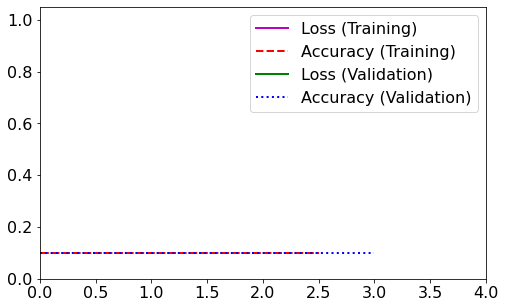

[Model3--Broken] Test loss: nan, test accuracy: 9.680%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       484
           1     0.0000    0.0000    0.0000       540
           2     0.0000    0.0000    0.0000       510
           3     0.0000    0.0000    0.0000       481
           4     0.0000    0.0000    0.0000       490
           5     0.0000    0.0000    0.0000       407
           6     0.0000    0.0000    0.0000       509
           7     0.0000    0.0000    0.0000       540
           8     0.0000    0.0000    0.0000       496
           9     0.0000    0.0000    0.0000       543

   micro avg     0.0000    0.0000    0.0000      5000
   macro avg     0.0000    0.0000    0.0000      5000
weighted avg     0.0000    0.0000    0.0000      5000
 samples avg     0.0000    0.0000    0.0000      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [34]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3b] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [35]:
###* put your answer here *###
#
# Answer:
# The problem was that the activation fuction of the output layer, 'tanh', was inproper for the multiclass 
# classification task. Should use 'softmax' instead.
# 

### Let's check if you fixed the issue.

[Model3--Fixed] Training Accuracy: 99.345%, Validation Accuracy: 97.260%


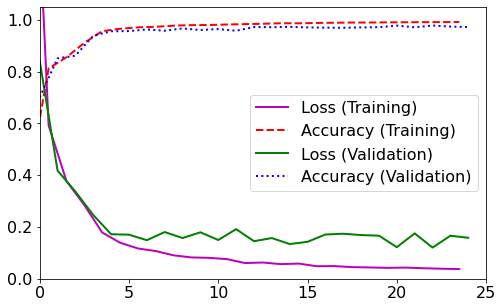

[Model3--Fixed] Test loss: 0.11752, test accuracy: 97.900%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9979    0.9752    0.9864       484
           1     0.9834    0.9870    0.9852       540
           2     0.9881    0.9804    0.9843       510
           3     0.9812    0.9771    0.9792       481
           4     0.9856    0.9776    0.9816       490
           5     0.9749    0.9558    0.9653       407
           6     0.9712    0.9921    0.9815       509
           7     0.9797    0.9815    0.9806       540
           8     0.9598    0.9637    0.9618       496
           9     0.9887    0.9705    0.9796       543

   micro avg     0.9811    0.9766    0.9789      5000
   macro avg     0.9811    0.9761    0.9785      5000
weighted avg     0.9812    0.9766    0.9789      5000
 samples avg     0.9766    0.9766    0.9766      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
name, model = create_compile_model3(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 3c] (5 points) Consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [37]:
def create_compile_model4(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    name = 'Model4--Fixed' if fixed else 'Model4--Broken'
    ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
    ###* the broken functionality when fixed=False (if necessary)
    if fixed:
        ###* put your code here (~1-2 lines) *###
        hidden_widths=[512, 128, 24]
        # comment/remove this line once you implement the fix
#         raise NotImplementedError 
    else:
        hidden_widths=[512, 128, 3, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Nadam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [38]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model4(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=0)

Model: "Model4--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 512)               401920    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               65664     
_________________________________________________________________
hidden_2 (Dense)             (None, 3)                 387       
_________________________________________________________________
hidden_3 (Dense)             (None, 24)                96        
_________________________________________________________________
output (Dense)               (None, 10)                250       
Total params: 468,317
Trainable params: 468,317
Non-trainable params: 0
_________________________________________________________________


[Model4--Broken] Training Accuracy: 11.235%, Validation Accuracy: 11.920%


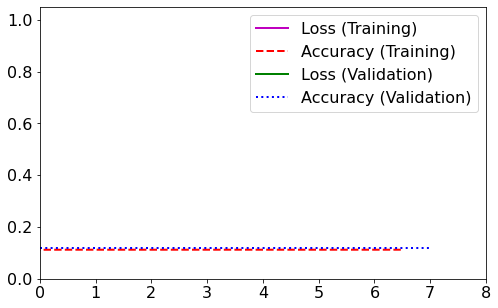

[Model4--Broken] Test loss: 2.30115, test accuracy: 10.800%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       484
           1     0.0000    0.0000    0.0000       540
           2     0.0000    0.0000    0.0000       510
           3     0.0000    0.0000    0.0000       481
           4     0.0000    0.0000    0.0000       490
           5     0.0000    0.0000    0.0000       407
           6     0.0000    0.0000    0.0000       509
           7     0.0000    0.0000    0.0000       540
           8     0.0000    0.0000    0.0000       496
           9     0.0000    0.0000    0.0000       543

   micro avg     0.0000    0.0000    0.0000      5000
   macro avg     0.0000    0.0000    0.0000      5000
weighted avg     0.0000    0.0000    0.0000      5000
 samples avg     0.0000    0.0000    0.0000      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [39]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3d] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [40]:
###* put your answer here *###
#
# Answer:
# The problem was that the architecture of the neural network was improper.
# It should be a shape of a funnel.
#

### Let's check if you fixed the issue.

[Model4--Fixed] Training Accuracy: 99.465%, Validation Accuracy: 97.680%


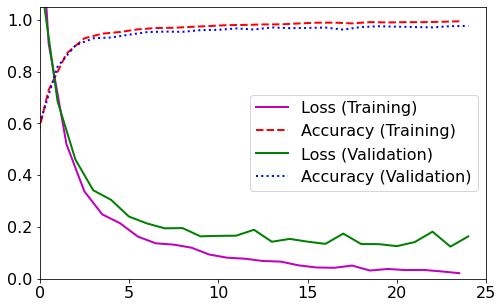

[Model4--Fixed] Test loss: 0.11740, test accuracy: 97.860%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9855    0.9855    0.9855       484
           1     0.9944    0.9926    0.9935       540
           2     0.9709    0.9824    0.9766       510
           3     0.9851    0.9626    0.9737       481
           4     0.9855    0.9735    0.9795       490
           5     0.9635    0.9730    0.9682       407
           6     0.9862    0.9843    0.9853       509
           7     0.9777    0.9722    0.9749       540
           8     0.9836    0.9677    0.9756       496
           9     0.9707    0.9779    0.9743       543

   micro avg     0.9805    0.9774    0.9790      5000
   macro avg     0.9803    0.9772    0.9787      5000
weighted avg     0.9806    0.9774    0.9790      5000
 samples avg     0.9774    0.9774    0.9774      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
name, model = create_compile_model4(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

### [Task 3e] (5 points) Consider the following model. It has several problems which prevent it from learning: can you figure out what those problems are? Fix them by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation! You can have more than one "if fixed:" branch if necessary.

In [42]:
def create_compile_model5(fixed, input_shape=784, num_outputs=10, verbose=True):
    name = 'Model5--Fixed' if fixed else 'Model5--Broken'
    hidden_widths=[256, 128, 24]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,))) 
    
    for i, hw in enumerate(hidden_widths):
        ###* Move the if fixed branch to where you want to use it, and create a corresponding else to preserve 
        ###* the broken functionality when fixed=False (if necessary)
        if fixed:
            ###* put your code here (~1-2 lines) *###
            model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        else:
            model.add(keras.layers.Dense(hw, activation='sigmoid', name='hidden_{}'.format(i)))
        
    if fixed:
        ###* put your code here (~1-2 lines) *###
        model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                kernel_initializer=keras.initializers.Zeros(), use_bias=False))
    else:
        model.add(keras.layers.Dense(num_outputs, activation='linear', name='output',
                                    bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                    kernel_initializer=keras.initializers.Zeros(), use_bias=False))
                  
    
    if fixed:
        ###* put your code here (~1-2 lines) *###
        opt = keras.optimizers.Nadam(lr=0.001, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    else:
        opt = keras.optimizers.Nadam(lr=0.01, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)

    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [43]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model5(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=0)

Model: "Model5--Broken"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 256)               200960    
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               32896     
_________________________________________________________________
hidden_2 (Dense)             (None, 24)                3096      
_________________________________________________________________
output (Dense)               (None, 10)                240       
Total params: 237,192
Trainable params: 237,192
Non-trainable params: 0
_________________________________________________________________


[Model5--Broken] Training Accuracy: 9.853%, Validation Accuracy: 10.140%


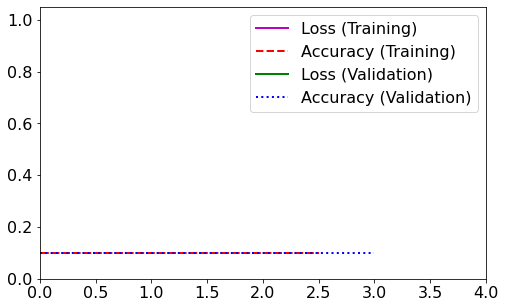

[Model5--Broken] Test loss: nan, test accuracy: 9.680%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       484
           1     0.0000    0.0000    0.0000       540
           2     0.0000    0.0000    0.0000       510
           3     0.0000    0.0000    0.0000       481
           4     0.0000    0.0000    0.0000       490
           5     0.0000    0.0000    0.0000       407
           6     0.0000    0.0000    0.0000       509
           7     0.0000    0.0000    0.0000       540
           8     0.0000    0.0000    0.0000       496
           9     0.0000    0.0000    0.0000       543

   micro avg     0.0000    0.0000    0.0000      5000
   macro avg     0.0000    0.0000    0.0000      5000
weighted avg     0.0000    0.0000    0.0000      5000
 samples avg     0.0000    0.0000    0.0000      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [44]:
# evaluate
evaluate_model(name, model, eval_data)

### [Task 3f] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [45]:
###* put your answer here *###
#
# Answer:
# The problem was threefold:
# 1. The activation function of the hiden layers were 'sigmoid' which is not as good as 'relu';
# 2. The activation function of the output layer was 'linear' which is improper for a multiclass classification task,
#    shold use 'softmax' instead;
# 3. The learning rate was too large which prevents the model from convergence.
#

### Let's check if you fixed the issue.

[Model5--Fixed] Training Accuracy: 99.663%, Validation Accuracy: 97.180%


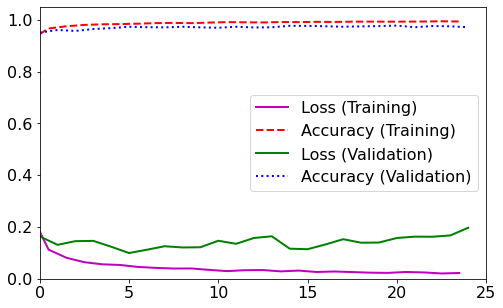

[Model5--Fixed] Test loss: 0.16887, test accuracy: 97.980%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9836    0.9897    0.9866       484
           1     0.9926    0.9926    0.9926       540
           2     0.9844    0.9902    0.9873       510
           3     0.9831    0.9667    0.9748       481
           4     0.9877    0.9816    0.9846       490
           5     0.9448    0.9681    0.9563       407
           6     0.9842    0.9804    0.9823       509
           7     0.9779    0.9852    0.9815       540
           8     0.9876    0.9597    0.9734       496
           9     0.9850    0.9705    0.9777       543

   micro avg     0.9817    0.9788    0.9803      5000
   macro avg     0.9811    0.9785    0.9797      5000
weighted avg     0.9818    0.9788    0.9803      5000
 samples avg     0.9788    0.9788    0.9788      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
name, model = create_compile_model5(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

## [Task 4] (30 points) Training CNNs

### In this task, you will train a convolutional neural network with an architecture you define. The goal is (of course) to train the best possible model, but the constraint is that the number of parameters must not exceed 500k (500,000). We will aim to achieve test/val accuracy above 98.5%.

### If you do this on a machine with a GPU, it will be very fast. Otherwise it may take 5 or 10 minutes to train the model for a few epochs, so we will use a subset of the training data for developing and testing the model.

#### Note: it is possible to achieve reasonably high accuracy (above 98.5%) with only about 50k parameters.

### To use a convolutional architecture we need to reshape the data

In [47]:
use_subset = True
tr_sz = 5000

# uncomment this line to use the full data
use_subset = False 

# reshape for use with CNN
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

cnn_dataset = (train_x, train_y, val_x, val_y, test_x, test_y)
if use_subset:
    cnn_dataset=(train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

### [Task 4a] (15 points) Fill in the implementation of create_compile_cnn() below with your chosen architecture. Ensure the total number of parameters chosen does not exceed 500k. You can look for insipiration for architectures on the web (or in books) if you like, but in that case you must provide a reference.

In [48]:
def create_compile_cnn(input_shape=(28, 28, 1), num_outputs=10, verbose=False):
    name = 'CNN'
    assert train_x.shape[1:] == input_shape # sanity check
    
    model = keras.models.Sequential(name=name)
    
    ### You can use any architecture but the output layer (with softmax activation is fixed). 
    ### You can also use whatever optimizer 'opt' you want (with your choice hyperparameters values)
    ### But the call to model.summary() must show that the number of parameters is within the constraint
    ### Note: you can import layers from keras.layers to make the code more compact.
    ###* put your code here (~10-20 lines) *###
    from tensorflow.keras import layers
    model.add(layers.Conv2D(32, 3, input_shape=input_shape, activation='relu', 
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, 3, activation='relu',
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, 5, strides=2, padding='same', activation='relu', 
                            kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4, seed=seed))
    
    model.add(layers.Conv2D(64, 3, activation='relu',
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, 3, activation='relu',
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', activation='relu',
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1))))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4, seed=seed))
    
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(128, activation='relu',
                           bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                           kernel_initializer=keras.initializers.Zeros(), 
                           use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4, seed=seed))
    
    model.add(layers.Dense(num_outputs, activation='softmax', name='output',
                           kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                           bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Nadam(lr=0.001, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [49]:
name, cnn_model = create_compile_cnn(verbose=True)

# note: you can change the number of epochs to train as long as it's reasonable
epochs = 30 if use_subset else 15
    
# note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
import time
begin = time.time()
eval_data = train_model(cnn_model, max_epochs=epochs, dataset=cnn_dataset, verbose=1)
end = time.time()
duration = (end - begin)/60.0
print("Training time in minutes: %s" % duration)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0       

#### Let's evaluate your CNN model. Does it achieve 98.5+% val/test accuracy?
#### *note: once you are confident in your model architecture, you MUST switch back to the full dataset*
#### to train the final version of the model (depending on your chosen architecture this could take 10-15 minutes if you are not on machine with GPU)

[CNN] Training Accuracy: 99.700%, Validation Accuracy: 99.420%


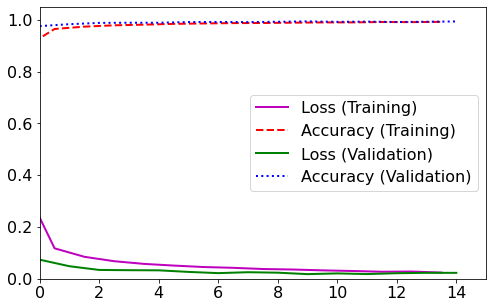

[CNN] Test loss: 0.02078, test accuracy: 99.280%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9979    0.9979    0.9979       484
           1     0.9945    1.0000    0.9972       540
           2     0.9980    0.9922    0.9951       510
           3     0.9938    0.9917    0.9927       481
           4     0.9839    0.9959    0.9899       490
           5     0.9975    0.9877    0.9926       407
           6     0.9883    1.0000    0.9941       509
           7     0.9963    0.9907    0.9935       540
           8     0.9919    0.9879    0.9899       496
           9     0.9944    0.9816    0.9880       543

   micro avg     0.9936    0.9926    0.9931      5000
   macro avg     0.9937    0.9926    0.9931      5000
weighted avg     0.9936    0.9926    0.9931      5000
 samples avg     0.9926    0.9926    0.9926      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
evaluate_model(name, cnn_model, eval_data)

### [Task 4b] (5 points) How long (in seconds/minutes) did your model take to train on the full dataset? Did you use a GPU?

In [53]:
###* put your answer here *###
#
# Answer:
# It took 5.77 mins to train my model on the full dataset.
# I didn't use any GPU.
#

### [Task 4c] (10 points) Explain how you decided on this architecture. (2-3 sentences is okay.) If you took inspiration from resources such as books/webpages, it's okay but you should include a reference in your answer.

In [54]:
###* put your answer here *###
#
# Answer:
# I took inspiration from this blog: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist.
# I noticed that the model easily get overfitted with simple CNN, 
# hence, I added batch normalizaiton and dropout and found them improve the performance a lot.
#

## [CIS6930 Additional Task -- Task 5] (25 points): CNN vs. Data Augmentation

### In this task we want to understand the impact of data augmentation on model quality. We pretend that we only have access to 2k examples from the MNIST training set and then multiply its size (by 5X) using data augmentation.

### The idea is to compare the performance of three models (all of which using your CNN architecture from Task 4): (1) the CNN trained on tr_x, ty_y (2k examples), (2) the CNN trained on the augmented data (10k examples), and (3) the CNN trained on 10k examples from the MNIST training set.

### [Task 5a] (15 points) Complete the code below to use data augmentation to produce a dataset of size 'data_aug_sz' from the tr_x and tr_y. You can use tf.keras' ImageDataGenerator with parameters chosen by you. 

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# dataset 1 -- 2k examples from mnist
tr_sz = 2000
cnn_dataset1 = (train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

# dataset 2 -- data augmentation (10k) starting from 2k examples from mnist
tr_x = train_x[:tr_sz]
tr_y = train_y[:tr_sz]

data_aug_sz = 10000

### Note: you will want to look very closely at the documentation of ImageDataGenerator (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
### in order to make sure you do not do strange things (e.g., it might not be a good idea to have vertical_flip=True, etc.)...
### Store the augmented data into aug_tr_x and aug_tr_y
###* put your code here (~5-10 lines) *###
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.2,0.8])

aug_tr_x = np.zeros((1, 28, 28, 1), float)
aug_tr_y = np.zeros((1, 10), float)
for i in range(4):
    datagen.fit(x=tr_x, augment=True, rounds=1)
    aug = datagen.flow(tr_x, tr_y, batch_size=1)
    for i in range(len(aug)):
        pair = next(aug)
        aug_tr_x = np.append(aug_tr_x, pair[0], axis=0)
        aug_tr_y = np.append(aug_tr_y, pair[1], axis=0)

aug_tr_x = np.append(tr_x, aug_tr_x[1:], axis=0)
aug_tr_y = np.append(tr_y, aug_tr_y[1:], axis=0)

# store the result
cnn_dataset2 = (aug_tr_x, aug_tr_y, val_x, val_y, test_x, test_y)
assert aug_tr_x.shape[0] == data_aug_sz and aug_tr_y.shape[0] == data_aug_sz

# dataset 3 -- 10k examples from mnist
cnn_dataset3 = (train_x[:data_aug_sz], train_y[:data_aug_sz], val_x, val_y, test_x, test_y)
assert aug_tr_x.shape == cnn_dataset3[0].shape


---------- Model 1 (train size: 2000) -----------
[CNN] Training Accuracy: 100.000%, Validation Accuracy: 95.100%


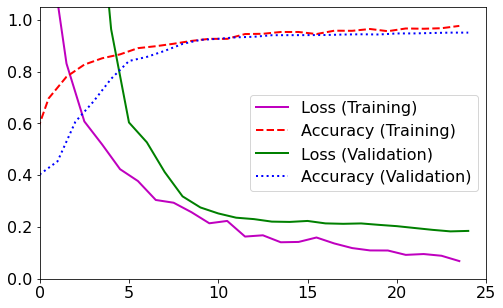

[CNN] Test loss: 0.19088, test accuracy: 95.440%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9596    0.9814    0.9704       484
           1     0.9761    0.9852    0.9806       540
           2     0.9633    0.9255    0.9440       510
           3     0.9573    0.9314    0.9442       481
           4     0.9637    0.9755    0.9696       490
           5     0.9407    0.9361    0.9384       407
           6     0.9557    0.9745    0.9650       509
           7     0.9577    0.9222    0.9396       540
           8     0.9526    0.9315    0.9419       496
           9     0.9445    0.9411    0.9428       543

   micro avg     0.9575    0.9506    0.9540      5000
   macro avg     0.9571    0.9504    0.9536      5000
weighted avg     0.9575    0.9506    0.9539      5000
 samples avg     0.9506    0.9506    0.9506      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



---------- Model 2 Data Augmented (train size: 10000) -----------
[CNN] Training Accuracy: 99.470%, Validation Accuracy: 96.960%


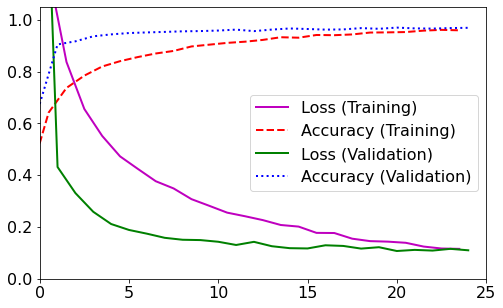

[CNN] Test loss: 0.11590, test accuracy: 97.120%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9757    0.9938    0.9846       484
           1     1.0000    0.9852    0.9925       540
           2     0.9681    0.9510    0.9594       510
           3     0.9810    0.9647    0.9727       481
           4     0.9835    0.9735    0.9785       490
           5     0.9311    0.9631    0.9469       407
           6     0.9710    0.9862    0.9786       509
           7     0.9848    0.9574    0.9709       540
           8     0.9715    0.9617    0.9666       496
           9     0.9543    0.9613    0.9578       543

   micro avg     0.9727    0.9698    0.9713      5000
   macro avg     0.9721    0.9698    0.9709      5000
weighted avg     0.9729    0.9698    0.9713      5000
 samples avg     0.9698    0.9698    0.9698      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



---------- Model 3 (train size: 10000) -----------
[CNN] Training Accuracy: 99.860%, Validation Accuracy: 98.160%


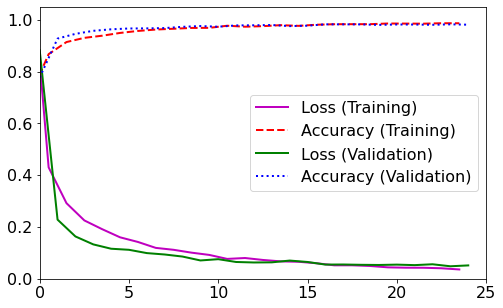

[CNN] Test loss: 0.05091, test accuracy: 98.540%
--- Classification Report: 
              precision    recall  f1-score   support

           0     0.9837    0.9979    0.9908       484
           1     0.9963    0.9963    0.9963       540
           2     0.9842    0.9784    0.9813       510
           3     0.9979    0.9771    0.9874       481
           4     0.9817    0.9857    0.9837       490
           5     0.9803    0.9803    0.9803       407
           6     0.9883    0.9941    0.9912       509
           7     0.9745    0.9889    0.9816       540
           8     0.9938    0.9718    0.9827       496
           9     0.9869    0.9724    0.9796       543

   micro avg     0.9868    0.9844    0.9856      5000
   macro avg     0.9868    0.9843    0.9855      5000
weighted avg     0.9868    0.9844    0.9856      5000
 samples avg     0.9844    0.9844    0.9844      5000



/home/tony/anaconda3/envs/deep-learning-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
### Now let's evaluate all three models

datasets = (cnn_dataset1, cnn_dataset2, cnn_dataset3)
names = ['Model 1 (train size: {})'.format(tr_sz), 'Model 2 Data Augmented (train size: {})'.format(data_aug_sz),
         'Model 3 (train size: {})'.format(data_aug_sz)]

for i, dataset in enumerate(datasets):
    name, cnn_model = create_compile_cnn(verbose=False)

    # note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
    eval_data = train_model(cnn_model, max_epochs=25, dataset=dataset, verbose=0)

    print('\n---------- {} -----------'.format(names[i]))
    evaluate_model(name, cnn_model, eval_data)

### [Task 5b] (10 points) What do you conclude about data augmentation? Does it help if you don't have enough data? Is it as good as having more real data? (A few sentences is fine.)

In [57]:
###* put your answer here *###
#
# Answer:
# From above results, about data augmentation, I can conclude that it can help improve the model's performance
# when we don't have enough data.
# But it is not as good as having more real data.
#